In [ ]:
import pandas as pd
fname = "/content/QMCI.csv"
with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
##This code reads the contents of the file
# and processes it to extract the header and the data
#TC96


['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
5936


In [ ]:
import numpy as np
AdjClose = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    AdjClose[i] = values[1]
    raw_data[i, :] = values[:]
#this code, using the NumPy library to process the data from the CSV file and create NumPy arrays for the Adjclose and raw data.
#TC96

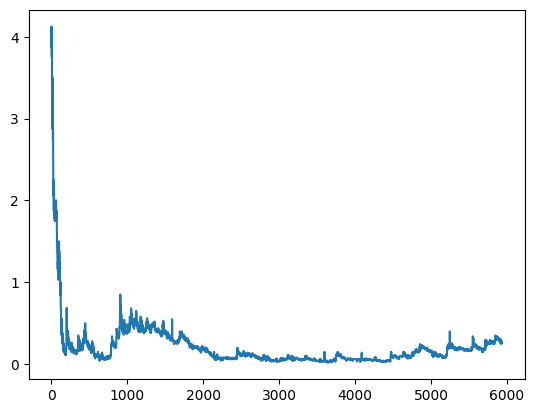

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(AdjClose)), AdjClose)
# This code will  plot the adjclose values against their respective indices.
#TC96

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)
#In the code, we are calculating the number of training, validation, and test samples
# based on the total number of samples in your dataset.
#TC96

num_train_samples: 2968
num_val_samples: 1484
num_test_samples: 1484


In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std
#In this code, we are performing feature scaling on the raw_data array using the mean and standard deviation
#TC96

In [ ]:
raw_data.shape

(5936, 6)

In [ ]:
import keras
sampling_rate = 2
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=AdjClose[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=AdjClose[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=AdjClose[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)
#The code will able to do the  preparing time series datasets for training, validation,
# and testing using Keras for a machine learning or deep learning model.
#TC96

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
#The code is iterating over the train_dataset and printing the shapes
# of samples and targets for the first batch of data.
#TC96

samples shape: (256, 120, 6)
targets shape: (256,)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#The code essentially creates a simple neural network for a regression task (predicting a continuous value)
# and evaluates its performance using the MAE metric on the test dataset
#TC96


Epoch 1/10
11/11 [==============================] - 2s 98ms/step - loss: 0.4857 - mae: 0.4362 - val_loss: 0.2446 - val_mae: 0.2647
Epoch 2/10
11/11 [==============================] - 1s 73ms/step - loss: 0.1655 - mae: 0.2648 - val_loss: 0.2430 - val_mae: 0.2900
Epoch 3/10
11/11 [==============================] - 1s 75ms/step - loss: 0.1304 - mae: 0.2465 - val_loss: 0.1933 - val_mae: 0.2725
Epoch 4/10
11/11 [==============================] - 1s 85ms/step - loss: 0.1052 - mae: 0.2235 - val_loss: 0.0793 - val_mae: 0.1752
Epoch 5/10
11/11 [==============================] - 1s 28ms/step - loss: 0.1079 - mae: 0.2319 - val_loss: 0.0940 - val_mae: 0.1830
Epoch 6/10
11/11 [==============================] - 1s 71ms/step - loss: 0.0497 - mae: 0.1470 - val_loss: 0.0758 - val_mae: 0.1553
Epoch 7/10
11/11 [==============================] - 2s 177ms/step - loss: 0.0972 - mae: 0.2134 - val_loss: 0.0457 - val_mae: 0.1193
Epoch 8/10
11/11 [==============================] - 1s 80ms/step - loss: 0.0354 - 

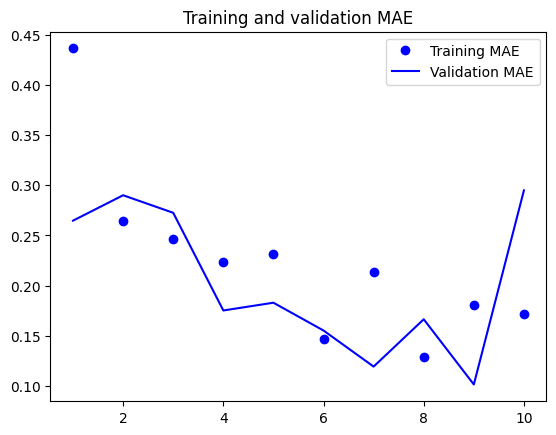

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
#The resulting plot shows how the training and validation MAE change over the course of training epochs.
#It can help you identify overfitting or underfitting,
# as well as assess the model's performance on both training and validation data.
#TC96

In [ ]:

for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 6)
targets shape: (256,)


In [ ]:
(sequence_length, raw_data.shape[-1])

(120, 6)

In [ ]:
output_seq_length = ((3 -  6+ 2 * 0) // 1) + 1
output_feature_channels = 8
print(output_seq_length)

-2


In [ ]:
import keras
from keras import layers

# Define the model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks, compile the model, and train
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Load the saved model
model = keras.models.load_model("jena_conv.tf")

# Evaluate the model on the test dataset
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")
#code is creating a 1D convolutional neural network for a regression task (predicting a continuous value)
# and evaluating its performance using the MAE metric on the test dataset.
#TC96


Epoch 1/10
11/11 [==============================] - 2s 138ms/step - loss: 0.0151 - mae: 0.0886 - val_loss: 0.0138 - val_mae: 0.0694
Epoch 2/10
11/11 [==============================] - 2s 109ms/step - loss: 0.0069 - mae: 0.0601 - val_loss: 0.0146 - val_mae: 0.0885
Epoch 3/10
11/11 [==============================] - 1s 68ms/step - loss: 0.0058 - mae: 0.0548 - val_loss: 0.0169 - val_mae: 0.0897
Epoch 4/10
11/11 [==============================] - 2s 157ms/step - loss: 0.0053 - mae: 0.0525 - val_loss: 0.0135 - val_mae: 0.0720
Epoch 5/10
11/11 [==============================] - 2s 105ms/step - loss: 0.0048 - mae: 0.0503 - val_loss: 0.0144 - val_mae: 0.0842
Epoch 6/10
11/11 [==============================] - 1s 68ms/step - loss: 0.0044 - mae: 0.0478 - val_loss: 0.0145 - val_mae: 0.0856
Epoch 7/10
11/11 [==============================] - 1s 58ms/step - loss: 0.0047 - mae: 0.0486 - val_loss: 0.0209 - val_mae: 0.1017
Epoch 8/10
11/11 [==============================] - 1s 48ms/step - loss: 0.0041

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#code is creating an LSTM-based neural network for a regression task (predicting a continuous value)
#and evaluating its performance using the MAE metric on the test dataset
#TC96

Epoch 1/10
11/11 [==============================] - 8s 568ms/step - loss: 0.0758 - mae: 0.2027 - val_loss: 0.0030 - val_mae: 0.0405
Epoch 2/10
11/11 [==============================] - 10s 899ms/step - loss: 0.0226 - mae: 0.1097 - val_loss: 0.0019 - val_mae: 0.0269
Epoch 3/10
11/11 [==============================] - 6s 511ms/step - loss: 0.0071 - mae: 0.0589 - val_loss: 0.0014 - val_mae: 0.0225
Epoch 4/10
11/11 [==============================] - 2s 90ms/step - loss: 0.0050 - mae: 0.0498 - val_loss: 0.0018 - val_mae: 0.0342
Epoch 5/10
11/11 [==============================] - 6s 523ms/step - loss: 0.0047 - mae: 0.0484 - val_loss: 0.0010 - val_mae: 0.0230
Epoch 6/10
11/11 [==============================] - 6s 556ms/step - loss: 0.0047 - mae: 0.0487 - val_loss: 9.1586e-04 - val_mae: 0.0215
Epoch 7/10
11/11 [==============================] - 5s 477ms/step - loss: 0.0045 - mae: 0.0479 - val_loss: 6.6656e-04 - val_mae: 0.0158
Epoch 8/10
11/11 [==============================] - 1s 91ms/step - l

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)
#this code demonstrates a basic simulation of an RNN's forward pass, where input data is processed through time steps,
# and the RNN's output sequence is computed based on learned weights and biases
#TC96

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
#code sets up the architecture for a SimpleRNN-based model that
# can process sequences of data with varying numbers of time steps and 14 input features
#TC96

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)
# code is for creating a Simple Recurrent Neural Network (SimpleRNN) model with a specific input shape
#and configuration and then printing the shape of the output.
#TC96

(None, 16)


In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)
# code is for creating a Simple Recurrent Neural Network (SimpleRNN) model with a specific input shape
#and configuration and then printing the shape of the output.
#TC96

(None, 120, 16)


In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
#This code creates a stacked SimpleRNN model with three layers. The first two layers return the full sequence of outputs,
# and the final layer returns only the output at the last time step.
#TC96

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
#code sets up a Long Short-Term Memory (LSTM) network with dropout layers to prevent overfitting during training. The LSTM layer captures
#sequential patterns in the data, and the dropout layers help improve generalization
#TC96

Epoch 1/10
11/11 [==============================] - 10s 506ms/step - loss: 0.0657 - mae: 0.2040 - val_loss: 0.0042 - val_mae: 0.0566
Epoch 2/10
11/11 [==============================] - 7s 616ms/step - loss: 0.0269 - mae: 0.1246 - val_loss: 9.0971e-04 - val_mae: 0.0208
Epoch 3/10
11/11 [==============================] - 3s 202ms/step - loss: 0.0191 - mae: 0.1041 - val_loss: 0.0022 - val_mae: 0.0386
Epoch 4/10
11/11 [==============================] - 4s 330ms/step - loss: 0.0160 - mae: 0.0950 - val_loss: 0.0043 - val_mae: 0.0556
Epoch 5/10
11/11 [==============================] - 3s 232ms/step - loss: 0.0130 - mae: 0.0853 - val_loss: 0.0016 - val_mae: 0.0284
Epoch 6/10
11/11 [==============================] - 3s 206ms/step - loss: 0.0122 - mae: 0.0812 - val_loss: 0.0013 - val_mae: 0.0226
Epoch 7/10
11/11 [==============================] - 4s 309ms/step - loss: 0.0111 - mae: 0.0764 - val_loss: 0.0015 - val_mae: 0.0264
Epoch 8/10
11/11 [==============================] - 3s 238ms/step - los

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)
#code configures an LSTM-based neural network model with recurrent dropout for regularization and the unroll option for optimization.
#TC96

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#code sets up a stacked GRU-based neural network with dropout layers to prevent overfitting during training.
#TC96

Epoch 1/10
11/11 [==============================] - 17s 978ms/step - loss: 0.0390 - mae: 0.1479 - val_loss: 0.0040 - val_mae: 0.0338
Epoch 2/10
11/11 [==============================] - 11s 1s/step - loss: 0.0124 - mae: 0.0848 - val_loss: 0.0018 - val_mae: 0.0215
Epoch 3/10
11/11 [==============================] - 12s 1s/step - loss: 0.0104 - mae: 0.0770 - val_loss: 0.0016 - val_mae: 0.0280
Epoch 4/10
11/11 [==============================] - 5s 384ms/step - loss: 0.0099 - mae: 0.0731 - val_loss: 0.0071 - val_mae: 0.0807
Epoch 5/10
11/11 [==============================] - 6s 504ms/step - loss: 0.0094 - mae: 0.0722 - val_loss: 0.0024 - val_mae: 0.0378
Epoch 6/10
11/11 [==============================] - 11s 1s/step - loss: 0.0082 - mae: 0.0669 - val_loss: 9.1715e-04 - val_mae: 0.0182
Epoch 7/10
11/11 [==============================] - 4s 379ms/step - loss: 0.0085 - mae: 0.0691 - val_loss: 0.0011 - val_mae: 0.0190
Epoch 8/10
11/11 [==============================] - 11s 1s/step - loss: 0.008

the performances of the RNN and LSTM high are less then I expected